In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import datasets
cifar_10 = datasets.fetch_openml('CIFAR_10_small')

#Tarea 3a: Realiza una descripción del dataset. Realiza los pasos necesarios de preprocesamiento que sean necesarios

In [3]:
cifar_10.DESCR

'**Author**: Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton    \n**Source**: [University of Toronto](https://www.cs.toronto.edu/~kriz/cifar.html) - 2009  \n**Please cite**: Alex Krizhevsky (2009) Learning Multiple Layers of Features from Tiny Images, Tech Report.\n\n**CIFAR-10 small**  \nThis is a 20,000 instance sample of the original CIFAR-10 dataset. Sampled randomly and stratified, with 2000 examples per class. Training and test set are merged. Find the corresponding task for the original train-test splits.\n\nCIFAR-10 is a labeled subset of the [80 million tiny images dataset](http://groups.csail.mit.edu/vision/TinyImages/). It (originally) consists 32x32 color images representing 10 classes of objects:  \n0. airplane  \n1. automobile          \n2. bird          \n3. cat          \n4. deer          \n5. dog          \n6. frog          \n7. horse          \n8. ship          \n9. truck          \n\nThe classes are completely mutually exclusive. There is no overlap between automobi

El dataset contiene imágenes de 32x32 bits con tres canales (RGB) pertenecientes a tres clases

In [4]:
cifar_10.target.value_counts()

2    2032
6    2030
8    2025
3    2016
0    2005
7    2001
4    1999
9    1981
1    1974
5    1937
Name: class, dtype: int64

In [5]:
all(cifar_10.data.isna().sum(axis=1)) == 0

True

Los datos están balanceados y no hay nulos, como cabe de esperar de un dataset de pruebas de sklearn

In [6]:
X, y = cifar_10.data, cifar_10.target

In [7]:
X.shape

(20000, 3072)

In [8]:
# Reescalamos
X /= 255

##Método PCA

Empecemos por aplicar PCA, un método de "fusiona" características para reducir el número total de ellas.

In [9]:
from sklearn.decomposition import PCA

PCA con 95% de la varianza explicada

In [ ]:
X_PCA = PCA(0.95).fit_transform(X)

In [ ]:
X_PCA.shape

(20000, 214)

Con PCA reducimos de 3072 a 214 características (aunque no sabemos qué representan)

##Método Umbral de la Varianza

In [15]:
from sklearn.feature_selection import VarianceThreshold
X_variance_methode = X.copy()
sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
X_variance_methode = sel.fit_transform(X_variance_methode)
X_variance_methode.shape[1]

85

Este método no nos sirve como selector de características, sin embargo quizá signifique algo el que se quede con todas las características.

##Método KBests

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_KBests_methode = X.copy()


# Intentemos quedarnos con 1000 características para reducir el peso del dataset
selector = SelectKBest(chi2, k=1000)
X_KBests = selector.fit_transform(X_KBests_methode, y)
X_KBests.shape[1]

1000

##Método RFE

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
X_RFE_methode = X.copy()

# Nuevamente, quedémonos con los 214 pixeles más representativos
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=214, step=1)
# rfe.fit(X, y)
# ranking = rfe.ranking_
# print(ranking)

Tiempo de ejecución inviable

#Tarea 3b: Entrega y evalúa al menos 3 algoritmos de clasificación de los vistos en clase, incluyendo redes de neuronas de forma obligatoria, para clasificar las imágenes en sus categorías. Utiliza las métricas adecuadas para evaluar cada algoritmo mediante los conjuntos de entrenamiento y test que se proporcionan en el propio dataset.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

##Red Neuronal

###Método PCA

Primero veamos cómo funciona con MLPClassifier.

In [ ]:
from keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size = 0.33, random_state = 42)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, batch_size=64)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print('Accuracy con tres capas ocultas de 128, 64, 32 neuronas : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Accuracy con tres capas ocultas de 128, 64, 32 neuronas : 0.4264


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.50      0.49       667
           1       0.50      0.46      0.48       668
           2       0.34      0.35      0.34       667
           3       0.27      0.29      0.28       634
           4       0.38      0.39      0.39       628
           5       0.37      0.37      0.37       643
           6       0.49      0.46      0.47       708
           7       0.48      0.48      0.48       627
           8       0.51      0.53      0.52       681
           9       0.45      0.44      0.45       677

    accuracy                           0.43      6600
   macro avg       0.43      0.43      0.43      6600
weighted avg       0.43      0.43      0.43      6600



Bastante malo usando MLP, intentemos con tensorflow

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim = 214, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(y_train.shape[1], activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
670/670 [==============================] - 4s 5ms/step - loss: 2.0389 - accuracy: 0.2549 - val_loss: 1.7684 - val_accuracy: 0.3698
Epoch 2/20
670/670 [==============================] - 3s 4ms/step - loss: 1.7898 - accuracy: 0.3605 - val_loss: 1.6899 - val_accuracy: 0.3974
Epoch 3/20
670/670 [==============================] - 3s 5ms/step - loss: 1.6816 - accuracy: 0.3938 - val_loss: 1.6326 - val_accuracy: 0.4187
Epoch 4/20
670/670 [==============================] - 3s 4ms/step - loss: 1.6037 - accuracy: 0.4302 - val_loss: 1.5872 - val_accuracy: 0.4299
Epoch 5/20
670/670 [==============================] - 3s 4ms/step - loss: 1.5580 - accuracy: 0.4465 - val_loss: 1.5634 - val_accuracy: 0.4537
Epoch 6/20
670/670 [==============================] - 3s 4ms/step - loss: 1.4964 - accuracy: 0.4709 - val_loss: 1.5447 - val_accuracy: 0.4463
Epoch 7/20
670/670 [==============================] - 4s 6ms/step - loss: 1.4514 - accuracy: 0.4807 - val_loss: 1.5319 - val_accuracy: 0.4545
Epoch 

Loss: 1.4824962615966797
Accuracy: 0.4875757694244385


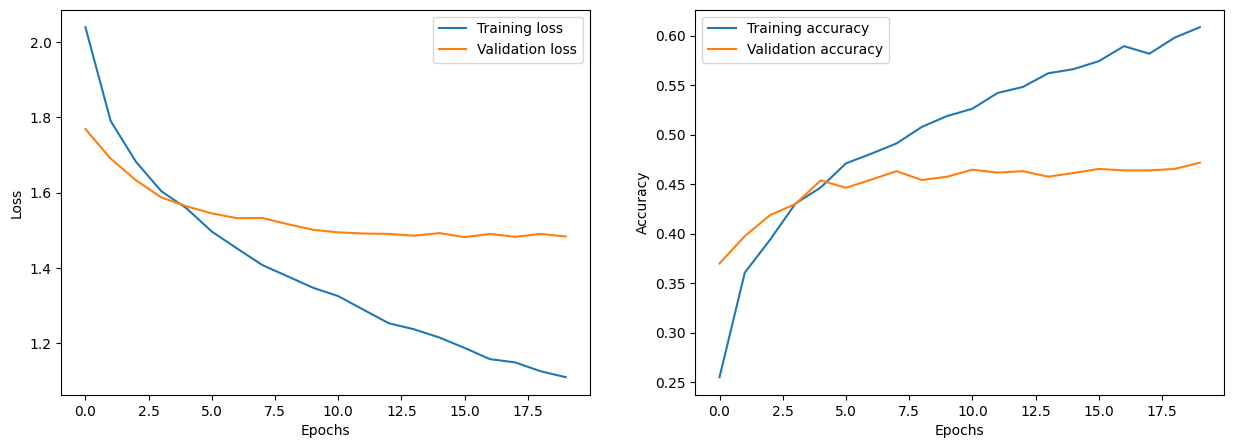

In [ ]:
def plot(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history.history['loss'], label='Training loss')
    ax[0].plot(history.history['val_loss'], label='Validation loss')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='Training accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation accuracy')

    ax[1].legend()

    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Accuracy')

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Loss: " + str(loss))
    print("Accuracy: " + str(accuracy))

plot(history)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = to_categorical(y_pred)
pca_accuracy_rnn = accuracy_score(y_test, y_pred)
pca_precision_rnn = precision_score(y_test, y_pred, average='micro')
print(classification_report(y_test, y_pred))

207/207 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.55      0.58      0.56       667
           1       0.58      0.53      0.56       668
           2       0.41      0.33      0.37       667
           3       0.33      0.33      0.33       634
           4       0.38      0.48      0.43       628
           5       0.45      0.36      0.40       643
           6       0.50      0.59      0.54       708
           7       0.54      0.59      0.56       627
           8       0.61      0.59      0.60       681
           9       0.54      0.47      0.50       677

   micro avg       0.49      0.49      0.49      6600
   macro avg       0.49      0.49      0.48      6600
weighted avg       0.49      0.49      0.49      6600
 samples avg       0.49      0.49      0.49      6600



Mejora respecto al MLP

Por último, probemos como se las apaña con un perceptrón

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(), max_iter=500, batch_size=64)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print('Accuracy perceptrón : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Accuracy perceptrón : 0.1223


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.22      0.33       667
           1       0.64      0.23      0.33       668
           2       0.40      0.04      0.07       667
           3       0.39      0.03      0.05       634
           4       0.37      0.05      0.09       628
           5       0.55      0.07      0.12       643
           6       0.49      0.16      0.24       708
           7       0.61      0.19      0.29       627
           8       0.60      0.21      0.31       681
           9       0.52      0.23      0.32       677

   micro avg       0.56      0.14      0.23      6600
   macro avg       0.52      0.14      0.22      6600
weighted avg       0.52      0.14      0.22      6600
 samples avg       0.13      0.14      0.14      6600



Aunque la precision aumenta, las demás métricas empeoran mucho

Para el resto de métodos solo probaremos el modelo implementado con tensorflow.

###Método KBests

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_KBests, y, test_size = 0.33, random_state = 42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
model = Sequential()
model.add(Dense(516, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(y_train.shape[1], activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
335/335 [==============================] - 3s 6ms/step - loss: 2.2401 - accuracy: 0.1531 - val_loss: 2.1168 - val_accuracy: 0.2149
Epoch 2/20
335/335 [==============================] - 1s 4ms/step - loss: 2.1075 - accuracy: 0.2103 - val_loss: 2.0438 - val_accuracy: 0.2384
Epoch 3/20
335/335 [==============================] - 2s 5ms/step - loss: 2.0611 - accuracy: 0.2254 - val_loss: 2.0142 - val_accuracy: 0.2649
Epoch 4/20
335/335 [==============================] - 1s 4ms/step - loss: 2.0317 - accuracy: 0.2413 - val_loss: 2.0040 - val_accuracy: 0.2709
Epoch 5/20
335/335 [==============================] - 1s 4ms/step - loss: 2.0176 - accuracy: 0.2464 - val_loss: 2.0581 - val_accuracy: 0.2407
Epoch 6/20
335/335 [==============================] - 2s 5ms/step - loss: 1.9981 - accuracy: 0.2628 - val_loss: 1.9772 - val_accuracy: 0.2937
Epoch 7/20
335/335 [==============================] - 1s 4ms/step - loss: 1.9868 - accuracy: 0.2611 - val_loss: 1.9854 - val_accuracy: 0.2892
Epoch 

Loss: 1.9722269773483276
Accuracy: 0.30287879705429077


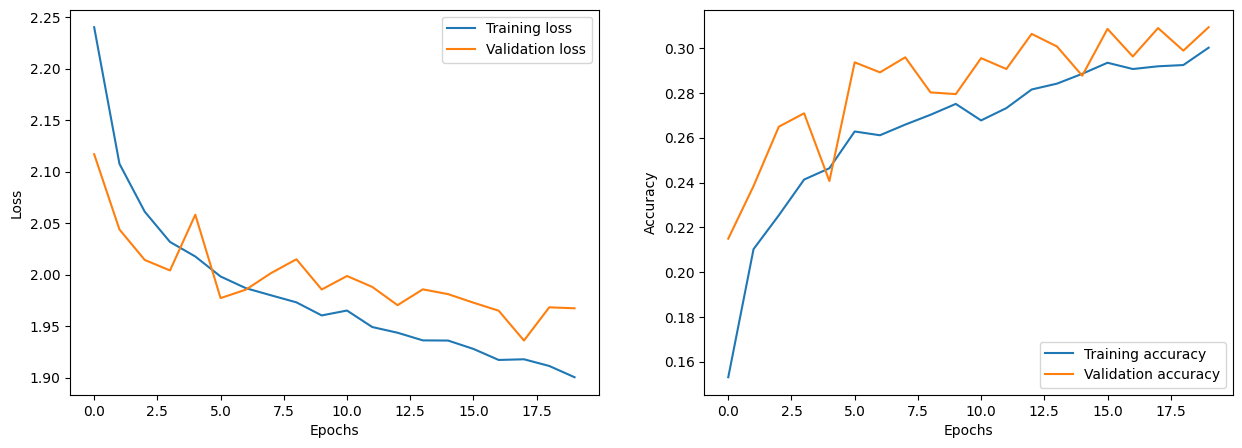

In [ ]:
plot(history)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = to_categorical(y_pred)
kb_accuracy_rnn = accuracy_score(y_test, y_pred)
kb_precision_rnn = precision_score(y_test, y_pred, average='micro')
print(classification_report(y_test, y_pred))

207/207 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.25      0.35       667
           1       0.45      0.31      0.37       668
           2       0.16      0.07      0.09       667
           3       0.18      0.20      0.19       634
           4       0.20      0.48      0.29       628
           5       0.43      0.18      0.26       643
           6       0.26      0.54      0.35       708
           7       0.35      0.19      0.25       627
           8       0.38      0.49      0.43       681
           9       0.43      0.29      0.35       677

   micro avg       0.30      0.30      0.30      6600
   macro avg       0.35      0.30      0.29      6600
weighted avg       0.35      0.30      0.29      6600
 samples avg       0.30      0.30      0.30      6600



Claramente no rinde igual reducir las características eliminando que 'fusionando'.

###Usemos todos los datos, pues es lo que sugirió el método de la varianza

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_variance_methode, y, test_size = 0.33, random_state = 42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim = X_variance_methode.shape[1], activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(y_train.shape[1], activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=32, verbose=1)

Epoch 1/40
335/335 [==============================] - 3s 5ms/step - loss: 2.2226 - accuracy: 0.1664 - val_loss: 2.0683 - val_accuracy: 0.2429
Epoch 2/40
335/335 [==============================] - 2s 5ms/step - loss: 2.0658 - accuracy: 0.2313 - val_loss: 1.9527 - val_accuracy: 0.2981
Epoch 3/40
335/335 [==============================] - 2s 7ms/step - loss: 1.9829 - accuracy: 0.2711 - val_loss: 1.8876 - val_accuracy: 0.3149
Epoch 4/40
335/335 [==============================] - 2s 5ms/step - loss: 1.9339 - accuracy: 0.2983 - val_loss: 1.8438 - val_accuracy: 0.3321
Epoch 5/40
335/335 [==============================] - 2s 5ms/step - loss: 1.8857 - accuracy: 0.3166 - val_loss: 1.8037 - val_accuracy: 0.3433
Epoch 6/40
335/335 [==============================] - 2s 5ms/step - loss: 1.8619 - accuracy: 0.3215 - val_loss: 1.7905 - val_accuracy: 0.3493
Epoch 7/40
335/335 [==============================] - 2s 5ms/step - loss: 1.8371 - accuracy: 0.3308 - val_loss: 1.7776 - val_accuracy: 0.3593
Epoch 

Loss: 1.5445996522903442
Accuracy: 0.4586363732814789


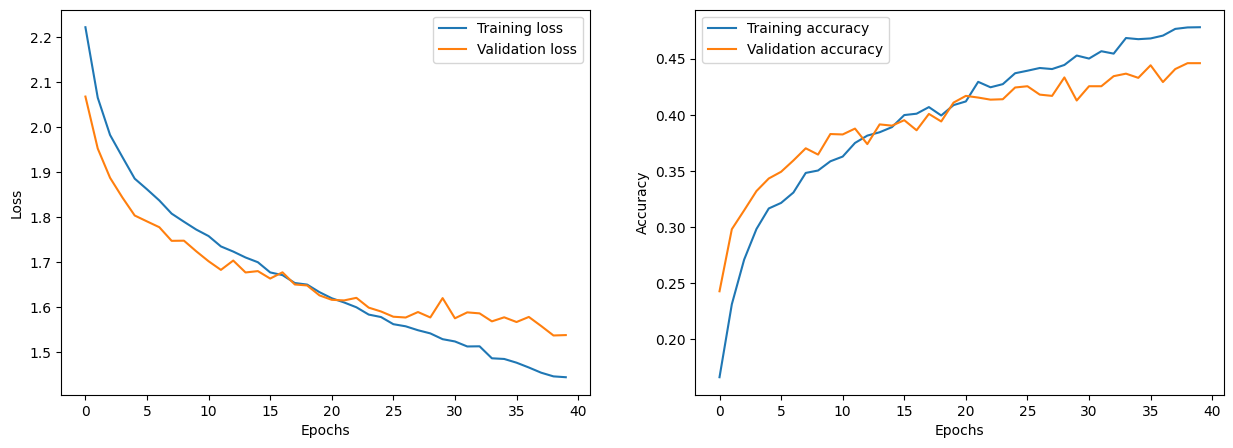

In [ ]:
plot(history)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = to_categorical(y_pred)
all_accuracy_rnn = accuracy_score(y_test, y_pred)
all_precision_rnn = precision_score(y_test, y_pred, average='micro')
print(classification_report(y_test, y_pred))

207/207 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       667
           1       0.48      0.67      0.56       668
           2       0.35      0.27      0.31       667
           3       0.33      0.32      0.33       634
           4       0.38      0.39      0.38       628
           5       0.47      0.26      0.33       643
           6       0.43      0.64      0.51       708
           7       0.51      0.54      0.53       627
           8       0.61      0.50      0.55       681
           9       0.48      0.51      0.49       677

   micro avg       0.46      0.46      0.46      6600
   macro avg       0.46      0.46      0.45      6600
weighted avg       0.46      0.46      0.45      6600
 samples avg       0.46      0.46      0.46      6600



Si usamos 'adam' como optimizador (que es el usado en los demás) obtenemos muy poca accuracy (en torno al 30%), pero si cambiamos el optimizador por 'sgd' mejoramos los resultados a la par de usar PCA, siendo menos eficiente computacionalmente, claro.

#SVM (SVC)

###Método PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size = 0.33, random_state = 42)

Tras varias pruebas, los mejores resultados se dan con kernel=rbf y c=10.

In [ ]:
svc = SVC(kernel='rbf', C=10.0, random_state=42)
svc.fit(X_train, y_train)

y_pred = list(svc.predict(X_test))
pca_accuracy_svc = accuracy_score(y_test, y_pred)
pca_precision_svc = precision_score(y_test, y_pred, average='micro')
print('Accuracy SVC con kernel rbf y c=10: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy SVC con kernel rbf y c=10: 0.4902


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55       667
           1       0.56      0.59      0.57       668
           2       0.37      0.38      0.37       667
           3       0.33      0.36      0.34       634
           4       0.40      0.41      0.41       628
           5       0.45      0.39      0.42       643
           6       0.55      0.53      0.54       708
           7       0.56      0.54      0.55       627
           8       0.60      0.61      0.61       681
           9       0.54      0.52      0.53       677

    accuracy                           0.49      6600
   macro avg       0.49      0.49      0.49      6600
weighted avg       0.49      0.49      0.49      6600



Las métricas empiezan a dar mejores resultados (aunque siguen siendo malos), a veces supera la barrera del 50%

###Método KBests

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_KBests, y, test_size = 0.33, random_state = 42)

In [ ]:
svc = SVC(kernel='rbf', C=10.0, random_state=42)
svc.fit(X_train, y_train)

y_pred = list(svc.predict(X_test))
kb_accuracy_svc = accuracy_score(y_test, y_pred)
kb_precision_svc = precision_score(y_test, y_pred, average='micro')
print('Accuracy SVC con kernel rbf y c=10: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy SVC con kernel rbf y c=10: 0.4259


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.51      0.50       667
           1       0.49      0.51      0.50       668
           2       0.32      0.32      0.32       667
           3       0.28      0.30      0.29       634
           4       0.34      0.40      0.37       628
           5       0.38      0.31      0.34       643
           6       0.46      0.42      0.44       708
           7       0.46      0.46      0.46       627
           8       0.54      0.57      0.55       681
           9       0.49      0.45      0.47       677

    accuracy                           0.43      6600
   macro avg       0.43      0.42      0.42      6600
weighted avg       0.43      0.43      0.43      6600



Bastante malo, aunque tiene cierta mejoría respecto de la red neuronal.

###Usando todas las características

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_variance_methode, y, test_size = 0.33, random_state = 42)

In [ ]:
svc = SVC(kernel='rbf', C=10.0, random_state=42)
svc.fit(X_train, y_train)

y_pred = list(svc.predict(X_test))
all_accuracy_svc = accuracy_score(y_test, y_pred)
all_precision_svc = precision_score(y_test, y_pred, average='micro')
print('Accuracy SVC con kernel rbf y c=10: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy SVC con kernel rbf y c=10: 0.4998


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       667
           1       0.56      0.59      0.57       668
           2       0.38      0.38      0.38       667
           3       0.35      0.40      0.37       634
           4       0.42      0.44      0.43       628
           5       0.47      0.40      0.43       643
           6       0.56      0.51      0.53       708
           7       0.57      0.55      0.56       627
           8       0.61      0.63      0.62       681
           9       0.55      0.55      0.55       677

    accuracy                           0.50      6600
   macro avg       0.50      0.50      0.50      6600
weighted avg       0.50      0.50      0.50      6600



Aunque son malos resultados es lo más alto obtenido hasta ahora

##Random Forest

###Método PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size = 0.33, random_state = 42)

In [ ]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=20)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
pca_accuracy_rfc = accuracy_score(y_test, y_pred)
pca_precision_rfc = precision_score(y_test, y_pred, average='micro')
print('Accuracy con 500 árboles y profundidad máxima de 20: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy con 500 árboles y profundidad máxima de 20: 0.4382


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.52      0.50       667
           1       0.47      0.51      0.49       668
           2       0.38      0.23      0.29       667
           3       0.31      0.29      0.30       634
           4       0.36      0.42      0.39       628
           5       0.39      0.31      0.35       643
           6       0.49      0.54      0.51       708
           7       0.51      0.44      0.47       627
           8       0.51      0.59      0.55       681
           9       0.44      0.51      0.47       677

    accuracy                           0.44      6600
   macro avg       0.43      0.44      0.43      6600
weighted avg       0.43      0.44      0.43      6600



Tras varias combinaciones 500 árboles con 20 de profundidad máxima parece ser lo que mejores resultados arroja.

###Método KBests

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_KBests, y, test_size = 0.33, random_state = 42)

In [ ]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=20)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
kb_accuracy_rfc = accuracy_score(y_test, y_pred)
kb_precision_rfc = precision_score(y_test, y_pred, average='micro')
print('Accuracy con 500 árboles y profundidad máxima de 20: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy con 500 árbolesy profundidad máxima de 20: 0.4005


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.49      0.50       667
           1       0.43      0.41      0.42       668
           2       0.34      0.24      0.28       667
           3       0.30      0.24      0.27       634
           4       0.32      0.39      0.35       628
           5       0.35      0.32      0.33       643
           6       0.39      0.45      0.42       708
           7       0.43      0.41      0.42       627
           8       0.48      0.52      0.50       681
           9       0.43      0.51      0.47       677

    accuracy                           0.40      6600
   macro avg       0.40      0.40      0.40      6600
weighted avg       0.40      0.40      0.40      6600



Malos resultados lo que una vez más demuestra que no es posible simplemente coger menos características de las originales para este problema

###Useando todas las características

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_variance_methode, y, test_size = 0.33, random_state = 42)

In [ ]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=30)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
all_accuracy_rfc = accuracy_score(y_test, y_pred)
all_precision_rfc = precision_score(y_test, y_pred, average='micro')
print('Accuracy con 500 árboles y profundidad máxima de 30: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy con 500 árboles y profundidad másima de 30: 0.4480


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.52      0.51       667
           1       0.51      0.50      0.50       668
           2       0.37      0.27      0.31       667
           3       0.30      0.26      0.28       634
           4       0.36      0.43      0.40       628
           5       0.39      0.35      0.37       643
           6       0.48      0.55      0.51       708
           7       0.48      0.46      0.47       627
           8       0.57      0.58      0.58       681
           9       0.45      0.55      0.50       677

    accuracy                           0.45      6600
   macro avg       0.44      0.45      0.44      6600
weighted avg       0.44      0.45      0.44      6600



Aumentando el parámetro max_depth solo consigue una poca mejoría respecto a PCA, sin embargo es mucho más costoso

#Conclusión

In [ ]:
data_acc = [[pca_accuracy_rnn, pca_accuracy_svc, pca_accuracy_rfc],[kb_accuracy_rnn, kb_accuracy_svc, kb_accuracy_rfc],[all_accuracy_rnn, all_accuracy_svc, all_accuracy_rfc]]
data_pre = [[pca_precision_rnn, pca_precision_svc, pca_precision_rfc],[kb_precision_rnn, kb_precision_svc, kb_precision_rfc],[all_precision_rnn, all_precision_svc, all_precision_rfc]]

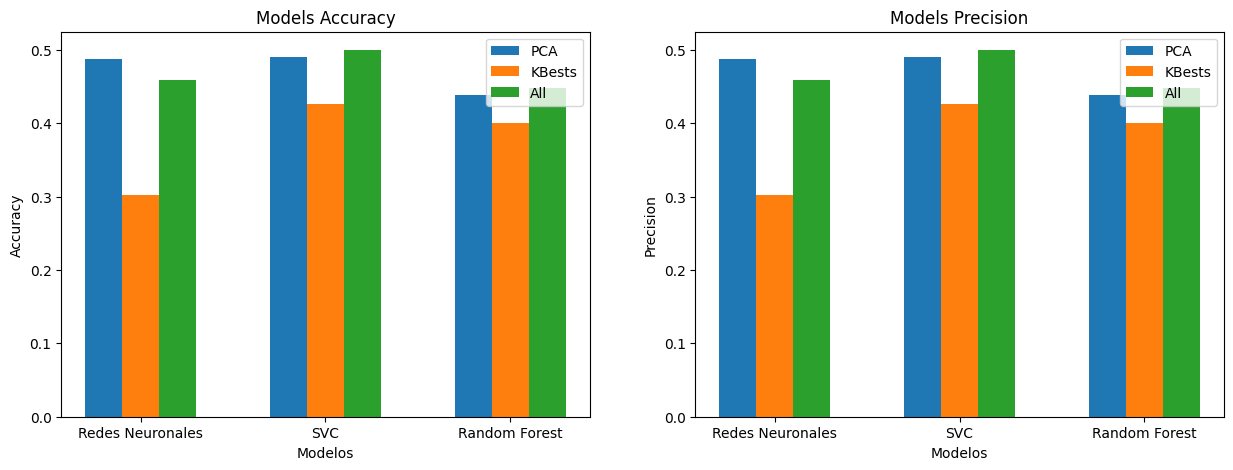

In [ ]:
labels = ['Redes Neuronales', 'SVC', 'Random Forest']
num_series = len(data_acc)
bar_width = 0.2

x = np.arange(len(labels))

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].bar(x + 0 * bar_width, data_acc[0], width=bar_width, label='PCA')
ax[0].bar(x + 1 * bar_width, data_acc[1], width=bar_width, label='KBests')
ax[0].bar(x + 2 * bar_width, data_acc[2], width=bar_width, label='All')

ax[0].set_xlabel('Modelos')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(f'Models Accuracy')
ax[0].set_xticks(x + ((num_series - 1) * bar_width) / 2)
ax[0].set_xticklabels(labels)
ax[0].legend()

ax[1].bar(x + 0 * bar_width, data_pre[0], width=bar_width, label='PCA')
ax[1].bar(x + 1 * bar_width, data_pre[1], width=bar_width, label='KBests')
ax[1].bar(x + 2 * bar_width, data_pre[2], width=bar_width, label='All')

ax[1].set_xlabel('Modelos')
ax[1].set_ylabel('Precision')
ax[1].set_title(f'Models Precision')
ax[1].set_xticks(x + ((num_series - 1) * bar_width) / 2)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.savefig('CIFAR_10.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

El mejor modelo para estos datos parece ser una SVC, tanto en términos de precision como de accuracy. En general usar todas las características es lo que mejor funciona, pero es muy costoso y usar PCA no supone una bajada en las métricas (de hecho es mejor con las redes neuronales). Lo que sí es seguro es que para un problema de imágenes, una red neuronal sin usar convoluciones no sirve para nada.